## Setup

In [1]:
# Import dependencies.
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pandas as pd

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

In [2]:
engine = create_engine("sqlite:///../Resources/dow.sqlite", echo=False)

In [3]:
engine.execute(text('SELECT * FROM dow LIMIT 5')).fetchall()

[(1, 1, 'AA', '2011-01-07', 15.82, 16.72, 15.78, 16.42, 239655616, None),
 (2, 1, 'AA', '2011-01-14', 16.71, 16.71, 15.64, 15.97, 242963398, None),
 (3, 1, 'AA', '2011-01-21', 16.19, 16.38, 15.6, 15.79, 138428495, None),
 (4, 1, 'AA', '2011-01-28', 15.87, 16.63, 15.82, 16.13, 151379173, None),
 (5, 1, 'AA', '2011-02-04', 16.18, 17.39, 16.18, 17.14, 154387761, None)]

In [4]:
inspector = inspect(engine)
columns = inspector.get_columns('dow')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
quarter INTEGER
stock TEXT
date TEXT
open_price FLOAT
high_price FLOAT
low_price FLOAT
close_price FLOAT
volume INTEGER
percent_change FLOAT


## Reflect and query dates

In [5]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(autoload_with=engine)
Dow = Base.classes.dow

In [6]:
session = Session(engine)

## Analysis

Analyze the Average prices (open, high, low, close) for all stocks in the Month of May

In [7]:
# Query for the stock and average prices (open, high, low, close) 
# for all stock in the month of May
# Sort the result by stock name
sel = [Dow.stock, 
       func.avg(Dow.open_price), 
       func.avg(Dow.high_price), 
       func.avg(Dow.low_price), 
       func.avg(Dow.close_price)]
may_averages = session.query(*sel).\
    filter(func.strftime("%m", Dow.date) == "05").\
    group_by(Dow.stock).\
    order_by(Dow.stock).all()
may_averages

[('AA', 16.8475, 17.3375, 16.4175, 16.747500000000002),
 ('AXP', 49.89750000000001, 51.07, 49.315, 50.5025),
 ('BA', 78.7175, 79.2175, 76.8825, 78.2125),
 ('BAC', 12.0, 12.235, 11.7325, 11.8775),
 ('CAT', 108.5525, 110.5975, 104.045, 106.4),
 ('CSCO', 17.067500000000003, 17.255000000000003, 16.5925, 16.8575),
 ('CVX', 103.9725, 105.72749999999999, 100.4575, 102.76249999999999),
 ('DD', 53.9625, 54.9225, 52.14, 53.21),
 ('DIS', 42.3, 42.8175, 41.11749999999999, 41.900000000000006),
 ('GE', 19.96, 20.175, 19.4875, 19.740000000000002),
 ('HD', 36.765, 37.51, 36.504999999999995, 36.7625),
 ('HPQ', 39.315, 40.14, 37.8425, 38.54),
 ('IBM', 169.7025, 171.58, 166.9375, 169.11749999999998),
 ('INTC', 23.0975, 23.67, 22.652500000000003, 23.0225),
 ('JNJ', 65.6575, 66.8475, 65.0575, 66.08749999999999),
 ('JPM', 44.015, 44.709999999999994, 43.019999999999996, 43.527499999999996),
 ('KO', 67.5775, 68.32499999999999, 66.75750000000001, 67.4725),
 ('KRFT', 34.305, 35.0225, 33.945, 34.7375),
 ('MCD', 

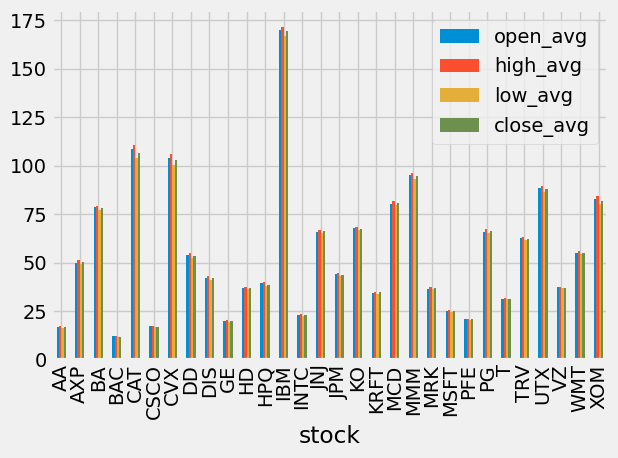

In [8]:
# Plot the Results in a Matplotlib bar chart
df = pd.DataFrame(may_averages, columns=['stock', 'open_avg', 'high_avg', 'low_avg', 'close_avg'])
df.set_index('stock', inplace=True)
df.plot.bar()
plt.tight_layout()
plt.show()

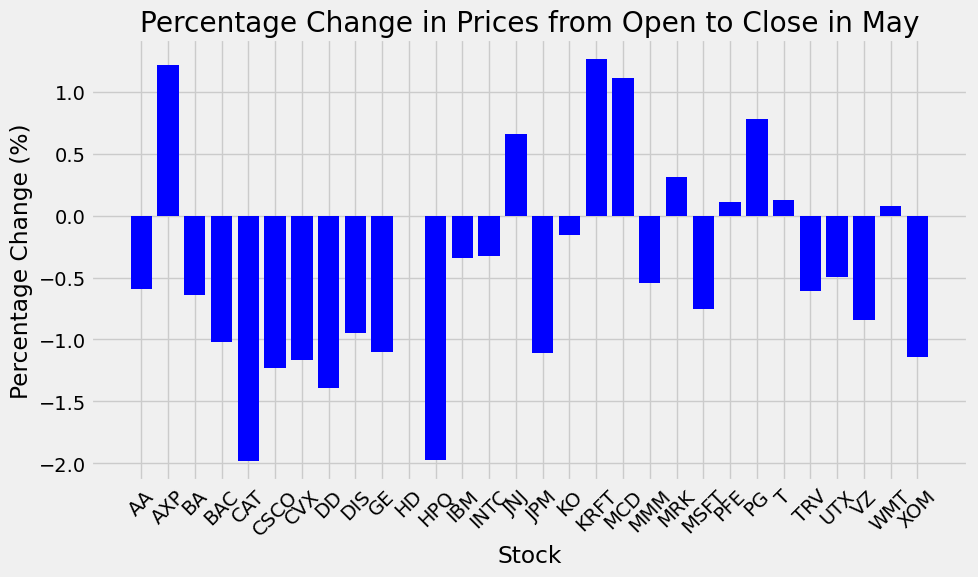

In [30]:
# Extract the data from the query result
stock_names = [row[0] for row in may_averages]
open_prices = [row[1] for row in may_averages]
close_prices = [row[4] for row in may_averages]

# Calculate the percentage change from open to close
percentage_changes = [(close - open) / open * 100 for open, close in zip(open_prices, close_prices)]

# Create a bar chart to visualize the percentage changes
plt.figure(figsize=(10, 6))
plt.bar(stock_names, percentage_changes, color='blue')
plt.xlabel('Stock')
plt.ylabel('Percentage Change (%)')
plt.title('Percentage Change in Prices from Open to Close in May')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


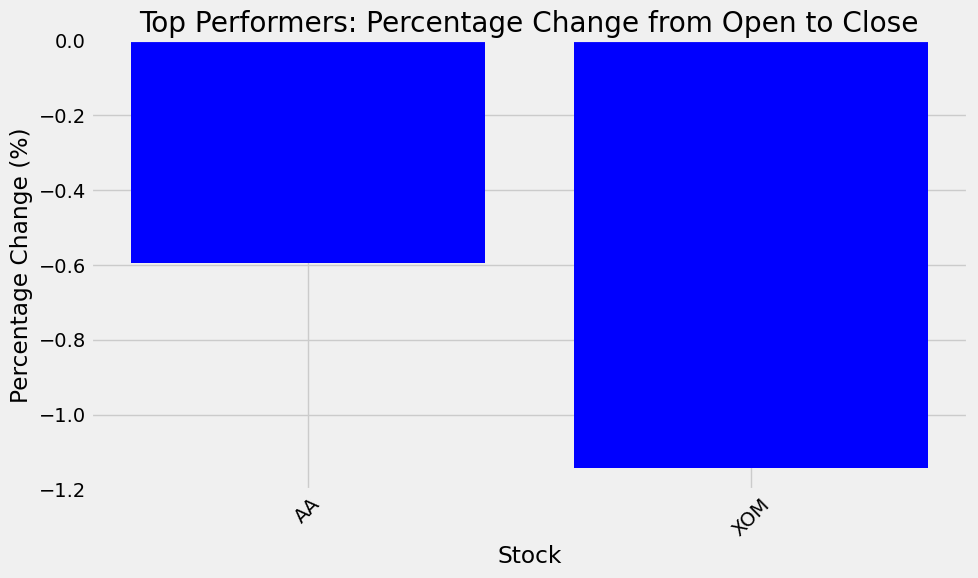

In [31]:
# Top performers for May
data = [
    ('AA', 16.8475, 17.3375, 16.4175, 16.747500000000002),
    # ... (other data)
    ('XOM', 82.8875, 84.27499999999999, 80.16999999999999, 81.94)
]

# Convert data to a DataFrame
columns = ['stock', 'open', 'high', 'low', 'close']
df = pd.DataFrame(data, columns=columns)

# Calculate percentage change
df['percentage_change'] = ((df['close'] - df['open']) / df['open']) * 100

# Sort by percentage change
df_sorted = df.sort_values(by='percentage_change', ascending=False)

# Select top performers (e.g., top 5)
top_performers = df_sorted.head(5)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(top_performers['stock'], top_performers['percentage_change'], color='blue')
plt.xlabel('Stock')
plt.ylabel('Percentage Change (%)')
plt.title('Top Performers: Percentage Change from Open to Close')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Calculating the high-low peak-to-peak (PTP) values for `IBM` stock after `2011-05-31`. 
* Note: high-low PTP is calculated using `high_price` - `low_price`
* Use a DateTime.date object in the query filter
* Use list comprehension to create a list of dictionaries from the query results
* Create a dataframe from the list of dictionaries
* Use the `boxplot()` method on the dataframe to plot PTP distribution statistics

In [9]:
# Design a query to calculate the PTP for stock `IBM` after May, 2011
import datetime as dt

date = dt.datetime(2011, 5, 31)

results = session.query(Dow.high_price - Dow.low_price, 
                        Dow.date).\
                  filter(Dow.date > date).filter(Dow.stock == 'IBM').all()

# List comprehension solution
ptp_rows = [{"Date": result[1], "PTP": result[0]} for result in results]
ptp_rows

[{'Date': '2011-06-03', 'PTP': 5.759999999999991},
 {'Date': '2011-06-10', 'PTP': 3.0900000000000034},
 {'Date': '2011-06-17', 'PTP': 3.579999999999984},
 {'Date': '2011-06-24', 'PTP': 3.219999999999999}]

<Figure size 1000x600 with 0 Axes>

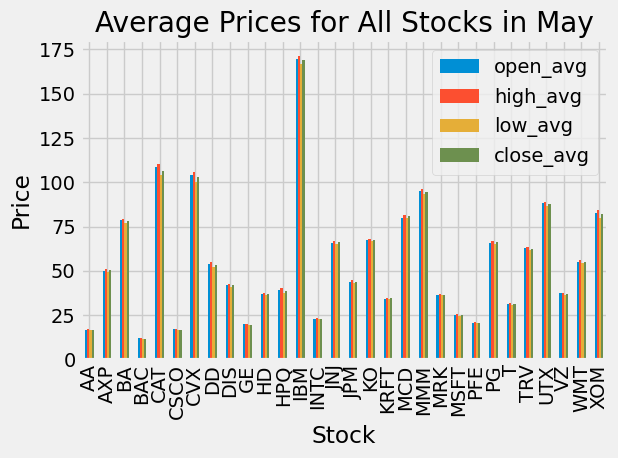

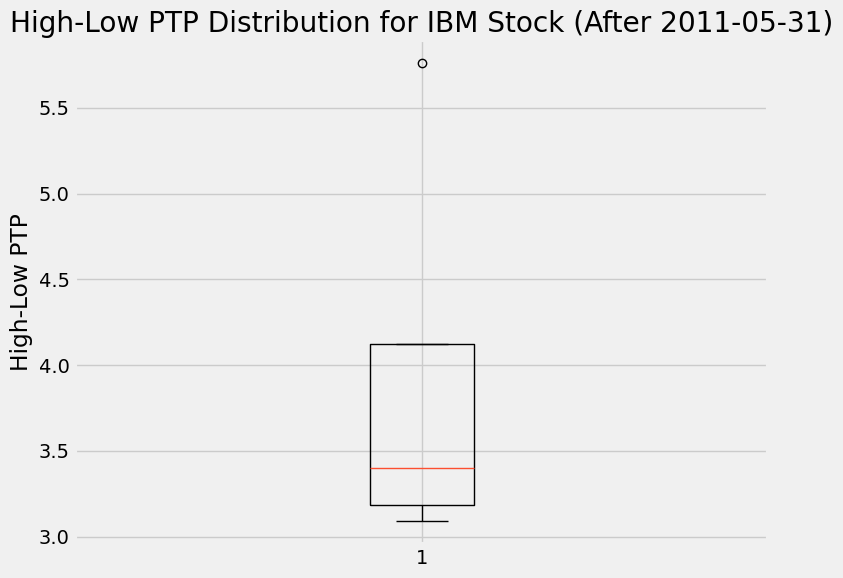

In [48]:
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
from sqlalchemy.ext.automap import automap_base
from datetime import date

# Create a session
session = Session(engine)

# Analyze the Average prices (open, high, low, close) for all stocks in the Month of May
sel = [
    Dow.stock,
    func.avg(Dow.open_price),
    func.avg(Dow.high_price),
    func.avg(Dow.low_price),
    func.avg(Dow.close_price)
]

may_averages = session.query(*sel).\
    filter(func.strftime("%m", Dow.date) == "05").\
    group_by(Dow.stock).\
    order_by(Dow.stock).all()

# Plot the results in a Matplotlib bar chart
df = pd.DataFrame(may_averages, columns=['stock', 'open_avg', 'high_avg', 'low_avg', 'close_avg'])
df.set_index('stock', inplace=True)

plt.figure(figsize=(10, 6))
df.plot.bar()
plt.title('Average Prices for All Stocks in May')
plt.xlabel('Stock')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Calculate high-low PTP values for IBM stock after 2011-05-31
filter_date = date(2011, 5, 31)
high_low_ptp_query = session.query(
    Dow.date,
    (Dow.high_price - Dow.low_price).label('high_low_ptp')
).filter(
    Dow.stock == 'IBM',
    func.date(Dow.date) > filter_date
).all()

# Close the session
session.close()

# Convert query results to a DataFrame
ptp_data = [{'date': result.date, 'high_low_ptp': result.high_low_ptp} for result in high_low_ptp_query]
ptp_df = pd.DataFrame(ptp_data)

# Create a box plot for PTP distribution
plt.figure(figsize=(8, 6))
plt.boxplot(ptp_df['high_low_ptp'])
plt.title(f'High-Low PTP Distribution for IBM Stock (After {filter_date})')
plt.ylabel('High-Low PTP')
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

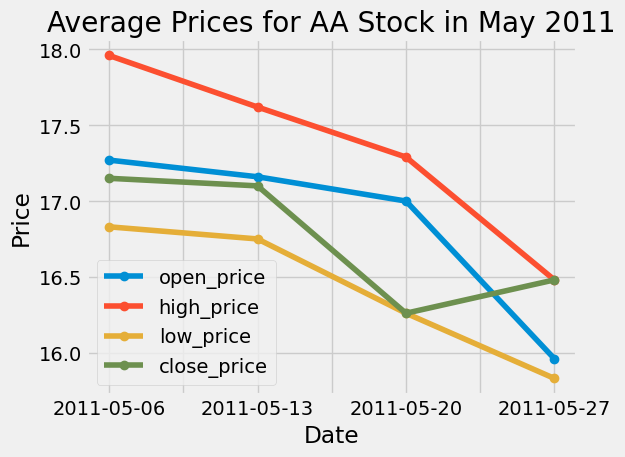

In [47]:
##AMERICAN AIRLINE ANALYSIS

# Query average prices for 'AA' stock in the month of May
sel = [
    Dow.date,
    Dow.open_price,
    Dow.high_price,
    Dow.low_price,
    Dow.close_price
]
filter_date = date(2011, 5, 1)
may_averages_query = session.query(*sel).filter(
    Dow.stock == 'AA',
    func.date(Dow.date) >= filter_date,
    func.date(Dow.date) < filter_date.replace(month=6)  # Filter for May only
).all()

# Close the session
session.close()

# Convert query results to a DataFrame
averages_data = [{
    'date': result.date,
    'open_price': result.open_price,
    'high_price': result.high_price,
    'low_price': result.low_price,
    'close_price': result.close_price
} for result in may_averages_query]
averages_df = pd.DataFrame(averages_data)

# Plot the average prices for 'AA' stock in May
plt.figure(figsize=(10, 6))
averages_df.set_index('date', inplace=True)
averages_df.plot(marker='o')
plt.title('Average Prices for AA Stock in May 2011')
plt.ylabel('Price')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

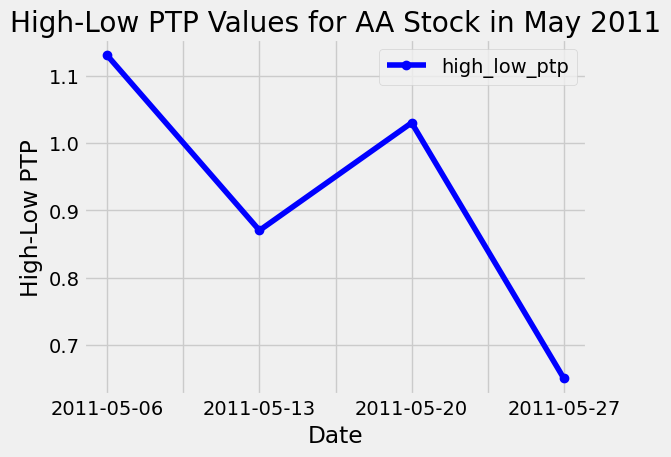

In [45]:
# Query high-low PTP values for 'AA' stock in the month of May
sel = [
    Dow.date,
    Dow.high_price - Dow.low_price
]
filter_date = date(2011, 5, 1)
may_ptp_query = session.query(*sel).filter(
    Dow.stock == 'AA',
    func.date(Dow.date) >= filter_date,
    func.date(Dow.date) < filter_date.replace(month=6)  # Filter for May only
).all()

# Close the session
session.close()

# Convert query results to a DataFrame
ptp_data = [{
    'date': result.date,
    'high_low_ptp': result[1]
} for result in may_ptp_query]
ptp_df = pd.DataFrame(ptp_data)

# Plot the high-low PTP values for 'AA' stock in May
plt.figure(figsize=(10, 6))
ptp_df.set_index('date', inplace=True)
ptp_df.plot(marker='o', color='blue')
plt.title('High-Low PTP Values for AA Stock in May 2011')
plt.ylabel('High-Low PTP')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [19]:

# Sample data
data = [
    (1, 1, 'AA', '2011-01-07', 15.82, 16.72, 15.78, 16.42, 239655616, None),
    (2, 1, 'AA', '2011-01-14', 16.71, 16.71, 15.64, 15.97, 242963398, None),
    (3, 1, 'AA', '2011-01-21', 16.19, 16.38, 15.6, 15.79, 138428495, None),
    # ... more data
]

# Convert the sample data into a DataFrame
import pandas as pd
columns = ['id', 'quarter', 'stock', 'date', 'open_price', 'high_price', 'low_price', 'close_price', 'volume', 'percent_change']
data_df = pd.DataFrame(data, columns=columns)

# Convert 'date' column to datetime type
data_df['date'] = pd.to_datetime(data_df['date'])

# Pivot the DataFrame to have dates as index and stocks as columns
closing_pivot = data_df.pivot(index='date', columns='stock', values='close_price')

# Calculate the daily returns for each stock
returns = closing_pivot.pct_change()
returns.dropna(inplace=True)

# Define the close_price variable
close_price = closing_pivot['AA']  # Choose a stock for close_price, such as 'AA'

# Rest of your code
# ... (the additional analysis and visualization code you provided)

# Show the plots
plt.show()



In [ ]:
# Additional Analysis and Visualization

# Calculate the daily returns for each stock
returns = close_price.pct_change()
returns.dropna(inplace=True)

# Calculate and visualize the cumulative returns of selected stocks
cumulative_returns = (1 + returns[[''AA'', 'AXP', 'BA', 'BAC', 'CAT']]).cumprod()

# Plot cumulative returns
cumulative_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns of Selected Stocks')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()


# Calculate and visualize the volatility (standard deviation of returns) of each stock
volatility = returns.std()
volatility.plot(kind='bar', figsize=(10, 6))
plt.title('Volatility of Stocks')
plt.xlabel('Stock')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.show()

# Calculate and visualize the rolling correlation between two selected stocks
stock1 = 'AA'
stock2 = 'AXP'
rolling_correlation = returns[stock1].rolling(window=30).corr(returns[stock2])
plt.figure(figsize=(10, 6))
plt.plot(rolling_correlation.index, rolling_correlation)
plt.title(f'Rolling Correlation between {stock1} and {stock2}')
plt.xlabel('Date')
plt.ylabel('Rolling Correlation')
plt.show()

# Apply a simple moving average trading strategy
short_window = 50
long_window = 200

signals = pd.DataFrame(index=closing_pivot.index)
signals['signal'] = 0.0
signals['short_mavg'] = closing_pivot['AA'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_mavg'] = closing_pivot['AA'].rolling(window=long_window, min_periods=1, center=False).mean()
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)

# Generate trading orders based on signals
signals['positions'] = signals['signal'].diff()

# Visualize the trading strategy and signals
plt.figure(figsize=(10, 6))
plt.plot(closing_pivot.index, closing_pivot['AA'], label='Price')
plt.plot(signals.index, signals['short_mavg'], label='50-day SMA', alpha=0.7)
plt.plot(signals.index, signals['long_mavg'], label='200-day SMA', alpha=0.7)
plt.plot(signals.loc[signals.positions == 1.0].index, signals.short_mavg[signals.positions == 1.0], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(signals.loc[signals.positions == -1.0].index, signals.short_mavg[signals.positions == -1.0], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('Moving Average Crossover Trading Strategy for AAPL')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
